In [26]:
# ============================
# 1. Imports
# ============================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ============================
# 2. Load Dataset
# ============================
df = pd.read_csv("Emotion_final.csv")   # change path if needed
print(df.head())

                                                Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


In [27]:
# ============================
# 3. Preprocess Text
# ============================
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)   # keep letters only
    return text

df["Text"] = df["Text"].astype(str).apply(clean_text)

# Encode labels
le = LabelEncoder()
df["Emotion"] = le.fit_transform(df["Emotion"])
classes = le.classes_
print("Classes:", classes)


Classes: ['anger' 'fear' 'happy' 'love' 'sadness' 'surprise']


In [28]:
# ============================
# 4. Train-Test Split
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    df["Text"], df["Emotion"], test_size=0.2, random_state=42, stratify=df["Emotion"]
)

In [29]:
# ============================
# 5. Tokenize + Pad
# ============================
max_words = 20000   # vocab size
maxlen = 100        # max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding="post", truncating="post")

y_train_cat = to_categorical(y_train, num_classes=len(classes))
y_test_cat = to_categorical(y_test, num_classes=len(classes))

In [30]:
# ============================
# 6. Build Model
# ============================
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(maxlen,)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(len(classes), activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

d:\Newfolderjnjj\envs\data_science\lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 100, 256)       │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,407,494 (9.18 MB)

 Trainable params: 2,407,494 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# ============================
# 7. Training
# ============================
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")

history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_test_pad, y_test_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/15
269/269 ━━━━━━━━━━━━━━━━━━━━ 69s 237ms/step - accuracy: 0.4372 - loss: 1.3622 - val_accuracy: 0.7335 - val_loss: 0.7753
Epoch 2/15
269/269 ━━━━━━━━━━━━━━━━━━━━ 69s 255ms/step - accuracy: 0.8218 - loss: 0.5096 - val_accuracy: 0.8772 - val_loss: 0.3674
Epoch 3/15
269/269 ━━━━━━━━━━━━━━━━━━━━ 67s 247ms/step - accuracy: 0.9183 - loss: 0.2532 - val_accuracy: 0.8959 - val_loss: 0.3223
Epoch 4/15
269/269 ━━━━━━━━━━━━━━━━━━━━ 68s 255ms/step - accuracy: 0.9477 - loss: 0.1721 - val_accuracy: 0.8956 - val_loss: 0.3281
Epoch 5/15
269/269 ━━━━━━━━━━━━━━━━━━━━ 80s 247ms/step - accuracy: 0.9590 - loss: 0.1331 - val_accuracy: 0.9073 - val_loss: 0.3246
Epoch 6/15
269/269 ━━━━━━━━━━━━━━━━━━━━ 69s 257ms/step - accuracy: 0.9653 - loss: 0.1164 - val_accuracy: 0.9005 - val_loss: 0.3324


In [32]:
# ============================
# 8. Evaluation
# ============================
loss, acc = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8959 - loss: 0.3223
Test Accuracy: 0.8959


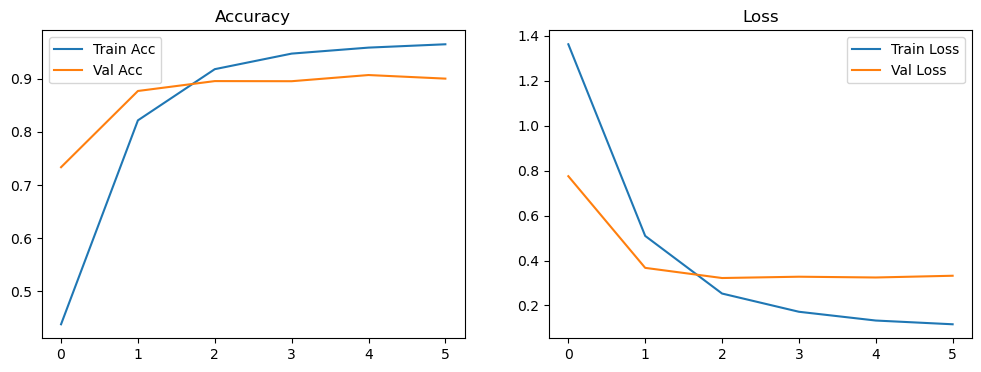

In [33]:
# ============================
# 9. Plot Training History
# ============================
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.show()

In [39]:
# ============================
# 10. Prediction Function
# ============================
def predict_emotion(text):
    seq = tokenizer.texts_to_sequences([clean_text(text)])
    pad = pad_sequences(seq, maxlen=maxlen, padding="post", truncating="post")
    pred = model.predict(pad)
    return classes[np.argmax(pred)]

# Example
print(predict_emotion("i am so happy"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
happy


In [36]:
#save model with vectorizer and encdoer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
    
model.save('model.h5')


In [ ]:
# After training
model.save("model.h5")


In [40]:
model.save("model.hdf5")


In [44]:
# ============================
# Load model, tokenizer, and encoder
# ============================
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load label encoder
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Load trained model
model = load_model('model.h5')

# Define maxlen (must be the same as used during training)
maxlen = 100   # 🔹 Replace with the correct value you used in training

# Define clean_text (example, update if you used more steps)
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.strip()

# ============================
# Prediction Function
# ============================
def predict_emotion(text):
    seq = tokenizer.texts_to_sequences([clean_text(text)])
    pad = pad_sequences(seq, maxlen=maxlen, padding="post", truncating="post")
    pred = model.predict(pad)
    label = le.inverse_transform([np.argmax(pred)])
    return label[0]

# Example
print(predict_emotion("i felling good today"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
happy
